In [1]:
import jax
import jax.numpy as jnp
import jax.scipy.linalg as linalg
import jax.random as jr
from helpers.noisy_gradient_descent import *
from helpers.gradient_descent import gradient_descent_update
from helpers.network import *
from helpers.stochastic_variance_amplified_gradient import *
from tqdm import tqdm


In [2]:
def calculate_error(learning_rates, sampled_values, expected_loss, x_0, H, final_time):
    error = []
    for learning_rate, sampled_value in zip(learning_rates, sampled_values):
        time = jnp.arange(0.0, final_time, learning_rate) + learning_rate
        expected_loss_value = expected_loss(
            time, x_0, H, learning_rate)
        error.append(jnp.max(jnp.abs(sampled_value - expected_loss_value)))
    return error


def fit_convergance_line(error, learning_rates):
    A = jnp.column_stack(
        (jnp.log(jnp.array(learning_rates)), jnp.ones((len(learning_rates), ))))
    log_error = jnp.log(jnp.array(error))
    coefficients, _, _, _ = jnp.linalg.lstsq(A, log_error)
    return coefficients


def sampled_loss(x, standard_normal_noise, H):
    return 0.5 * (x - standard_normal_noise).T @ H @ (x - standard_normal_noise) - 0.5 * jnp.trace(H)


@jax.jit
@partial(jax.vmap, in_axes=(0, None, None, None))
def expected_first_order_loss(time, initial_value, H, learning_rate):
    decay_term = 0.5 * initial_value.T @ H @ linalg.expm(
        -2.0 * time * H) @ initial_value
    # Eigenvalue in ascending order
    eigenvalues, _ = linalg.eigh(H)
    noise_term = 0.25 * learning_rate * jnp.sum(
        jnp.square(eigenvalues) * (1 - jnp.exp(-2.0 * time * eigenvalues)))
    return decay_term + noise_term


@jax.jit
@partial(jax.vmap, in_axes=(0, None, 0, None))
def stochastic_gradient_update(x, H, gamma, learning_rate):
    gradient = jax.grad(sampled_loss)(x, gamma, H)
    updated_x = x - learning_rate * gradient
    value = 0.5 * updated_x.T @ H @ updated_x
    return value, updated_x


In [3]:
key = jr.PRNGKey(4)
dimension = 3
initial_value_noise_scaling = 5.0
final_time = 2.0
number_of_samples = 100000
learning_rates = 2.0**jnp.arange(-1, -5, -1)

H = jnp.identity(dimension)
key, subkey = jr.split(key)
x_0 = initial_value_noise_scaling * jr.normal(subkey,
                                                        (dimension,))
average_sampled_values = [[] for i in range(len(learning_rates))]
sampled_values = [[] for i in range(len(learning_rates))]
for index, learning_rate in enumerate(learning_rates):
    max_iterations = int(final_time / learning_rate)
    x = jnp.tile(x_0, (number_of_samples, 1))
    for _ in tqdm(range(max_iterations)):
        key, subkey = jr.split(key)
        normal_noise = jr.normal(
            subkey, (number_of_samples, dimension))
        value, x = stochastic_gradient_update(x, H, normal_noise,
                                                learning_rate)
        average_sampled_values[index].append(jnp.average(value))
        sampled_values[index].append(value)
average_sampled_values = [jnp.array(sampled_value)
                    for sampled_value in average_sampled_values]
sampled_values = [jnp.array(sampled_value)
                  for sampled_value in sampled_values]
first_order_error = calculate_error(
    learning_rates, average_sampled_values, expected_first_order_loss, x_0, H, final_time)

100%|██████████| 32/32 [00:00<00:00, 238.73it/s]


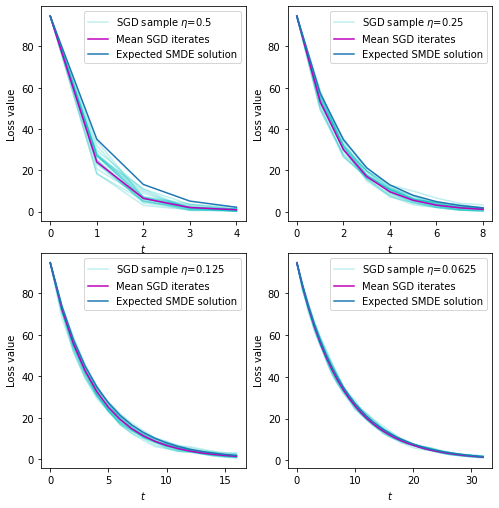

In [12]:
fig, axes = plt.subplots(2,2)
fig.set_figwidth(7)
fig.set_figheight(7)
fig.tight_layout()
for i, learning_rate in enumerate(learning_rates):
    average_values = jnp.insert(
        average_sampled_values[i], 0, 0.5 * x_0.T @ H @ x_0)
    # values = jnp.insert(
    #     sampled_values[i], 0, 0.5 * x_0.T @ H @ x_0)
    for j in range(0, number_of_samples, 5000):
        values_plt = jnp.insert(sampled_values[i][:,j], 0, 0.5 * x_0.T @ H @ x_0)
        if j == 0:
            axes[i//2, i % 2].plot(values_plt, 'c',
                                   label=f'SGD sample $\eta$={learning_rate}', alpha=0.25)
        else:
            axes[i//2, i % 2].plot(values_plt, 'c', alpha=0.25)
    axes[i//2, i % 2].plot(average_values, 'm',
                           label=f"Mean SGD iterates")
    # axes[i//2, i % 2].set_title(f'Learnig rate $\eta$={learning_rate}')
    time = jnp.arange(0.0, final_time + learning_rate,
                      learning_rate)
    expected_first_order_loss_value = expected_first_order_loss(
        time, x_0, H, learning_rate)
    axes[i//2,i%2].plot(expected_first_order_loss_value,
             label='Expected SMDE solution')
    axes[i//2,i%2].set_xlabel('$t$')
    axes[i//2,i%2].set_ylabel('Loss value')
    axes[i//2,i%2].legend()
plt.savefig('../seminar_talk/plots/sde_sgd.pdf')

In [9]:
first_order_coefficients = fit_convergance_line(
    first_order_error, learning_rates)
f'Exponent: {first_order_coefficients[0]:.3f}'

'Exponent: 1.098'

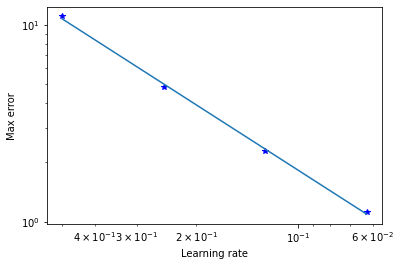

In [51]:
for learning_rate, error in zip(learning_rates, first_order_error):
    plt.plot(learning_rate,
             error,
             'b*')
t = jnp.linspace(learning_rates[-1], learning_rates[0], 1000)
y = jnp.exp(first_order_coefficients[1]) * t**first_order_coefficients[0]
plt.plot(t, y, '-')
plt.gca().invert_xaxis()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Learning rate')
plt.ylabel('Max error');
plt.savefig('../seminar_talk/plots/convergence_rate.pdf')